# Vocabulary Analysis Workshop

## Modeling

Now that we have explored the vocabulary of the different segments of this corpus, let's see if we can predict whether or not a document belongs in a given segment. We can use what we've learned about the vocabulary to make educated guesses about what features we should use.

In [1]:
from __future__ import division, print_function

%matplotlib inline

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output, display

from collections import OrderedDict
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
from sklearn import feature_extraction as skfeatex
from sklearn import metrics as skmetrics
from sklearn import tree as sktree
from sklearn.model_selection import cross_val_predict

from vocab_analysis import *

import answers

In [2]:
jobs_df = pd.read_pickle('./data/ngrams.pickle')

In [3]:
jobs_df.head()

,description,experience,education,is_hourly,is_part_time,is_supervisor,tokens,stems,lemmas,cleaned_lemmas,sentences,bigrams,trigrams,quadrigrams
id,,,,,,,,,,,,,,
0,THE COMPANY Employer is a midstream service...,5+,none,False,False,True,"[THE, COMPANY, Employer, is, a, midstream, ser...","[the, compani, employ, is, a, midstream, servi...","[the, company, employer, be, a, midstream, ser...","[employer, midstream, service, provider, onsho...","[[employer, midstream, service, provider, onsh...","[employer-midstream, midstream-service, servic...","[employer-midstream-service, midstream-service...","[employer-midstream-service-provider, midstrea..."
1,ICR Staffing is now accepting resumes for Indu...,2-5,none,False,False,False,"[ICR, Staffing, is, now, accepting, resumes, f...","[icr, staf, is, now, accept, resum, for, indus...","[icr, staff, be, now, accept, resume, for, ind...","[icr, staff, accept, resume, industrial, maint...","[[icr, staff, accept, resume, industrial, main...","[icr-staff, staff-accept, accept-resume, resum...","[icr-staff-accept, staff-accept-resume, accept...","[icr-staff-accept-resume, staff-accept-resume-..."
2,This is a great position for the right person....,none,none,False,True,False,"[This, is, a, great, position, for, the, right...","[this, is, a, great, posit, for, the, right, p...","[this, be, a, great, position, for, the, right...","[great, right, person, healthcareseeker, estab...","[[great, right, person], [healthcareseeker, es...","[great-right, right-person, healthcareseeker-e...","[great-right-person, healthcareseeker-establis...","[healthcareseeker-establish-place-register, es..."
3,A large multi-specialty health center is expan...,none,none,False,False,False,"[A, large, multi, -, specialty, health, center...","[a, larg, multi, specialti, health, center, is...","[a, large, multi, specialty, health, center, b...","[large, multi, specialty, health, center, expa...","[[large, multi, specialty, health, center, exp...","[large-multi, multi-specialty, specialty-healt...","[large-multi-specialty, multi-specialty-health...","[large-multi-specialty-health, multi-specialty..."
4,JOB PURPOSE: The Account Director is respon...,5+,bs-degree-needed,False,False,True,"[JOB, PURPOSE, :, The, Account, Director, is, ...","[job, purpos, the, account, director, is, resp...","[job, purpose, the, account, director, be, res...","[purpose, account, director, responsible, mana...","[[purpose, account, director, responsible, man...","[purpose-account, account-director, director-r...","[purpose-account-director, account-director-re...","[purpose-account-director-responsible, account..."


We will use the `TfidfVectorizer` from scikit-learn to generate our features. It uses an analyzer to process text and then creates feature values based the $\mbox{TF.IDF}$ of a term within a document.

In [4]:
print(skfeatex.text.TfidfVectorizer.__doc__)

Convert a collection of raw documents to a matrix of TF-IDF features.

    Equivalent to CountVectorizer followed by TfidfTransformer.

    Read more in the :ref:`User Guide <text_feature_extraction>`.

    Parameters
    ----------
    input : string {'filename', 'file', 'content'}
        If 'filename', the sequence passed as an argument to fit is
        expected to be a list of filenames that need reading to fetch
        the raw content to analyze.

        If 'file', the sequence items must have a 'read' method (file-like
        object) that is called to fetch the bytes in memory.

        Otherwise the input is expected to be the sequence strings or
        bytes items are expected to be analyzed directly.

    encoding : string, 'utf-8' by default.
        If bytes or files are given to analyze, this encoding is used to
        decode.

    decode_error : {'strict', 'ignore', 'replace'}
        Instruction on what to do if a byte sequence is given to analyze that
        conta

Let's load all of our functions back so we can use them as analyzers.

In [5]:
from my_tokenize import tokenize
from my_lemmatize import lemmatize, english_lemmas
from my_stopword_removal import stopword_removal
from my_lemma_sentences import lemma_sentences
from my_ngram_func import ngram_func

The `token_analyzer` will only tokenize the document.

In [6]:
def token_analyzer(description):
    return tokenize(description)

The `lemma_analyzer` will tokenize and lemmatize the document.

In [7]:
def lemma_analyzer(description):
    return lemmatize(tokenize(description), english_lemmas)

The `clean_lemma_analyzer`, will tokenize, lemmatize, and then remove stop words.

In [8]:
def clean_lemma_analyzer(description):
    return stopword_removal(lemmatize(tokenize(description), english_lemmas))

The `bigram_analyzer` will split into sentences, tokenize, lemmatize, remove stop words, and then generate bigrams as our terms

In [9]:
def bigram_analyzer(description):
    lemmatized_sentences = lemma_sentences(description)
    bigrams = ngram_func(2)(lemmatized_sentences)
    return bigrams

The `trigram_analyzer` will split into sentences, tokenize, lemmatize, remove stop words, and then generate trigrams as our terms

In [10]:
def trigram_analyzer(description):
    lemmatized_sentences = lemma_sentences(description)
    trigrams = ngram_func(3)(lemmatized_sentences)
    return trigrams

The `full_analyzer` will split into sentences, tokenize, lemmatize, remove stop words, and then generate bigrams and trigrams. It will use the cleaned lemmas, bigrams and trigrams as our terms.

In [11]:
def full_analyzer(description):
    lemmatized_sentences = lemma_sentences(description)
    unigrams = [unigram for sentence in lemmatized_sentences for unigram in sentence]
    bigrams = ngram_func(2)(lemmatized_sentences)
    trigrams = ngram_func(3)(lemmatized_sentences)
    return unigrams + bigrams + trigrams

Our tasks are
- education: predict what level of education is needed for a job (none, associate-needed, bs-degree-needed, ms-or-phd-needed)
- experience: predict how many years of experience is needed for a job (none, 1-2, 2-5, 5+)
- is_hourly: predict whether a job is an hourly or not (True, False)
- is_part_time: predict whether a job is part time or not (True, False)
- is_supervisor: predict whether a job is a supervisory position or not (True, False)


In [12]:
tasks = ['education', 'experience', 'is_hourly', 'is_part_time', 'is_supervisor']

Covering how to use scikit-learn is outside the scope of this tutorial. If you want to know more about using scikit-learn, check out Sebastian Rashka's tutorial [_Learning scikit-learn -- An Introduction to Machine Learning in Python_](https://www.youtube.com/watch?v=9fOWryQq9J8). 

We'll be modeling with decision trees ([wiki]()) ([_Python for Data Science_ by Joe McCarthy](http://nbviewer.jupyter.org/github/gumption/Python_for_Data_Science/blob/master/Python_for_Data_Science_all.ipynb#4.-Using-Python-to-Build-and-Use-a-Simple-Decision-Tree-Classifier)). Rather than go into the details of decision trees, let's look at one.

![tree](tree.png)

This is a tree that was built for the is_hourly task.

I've simplified working with these models by creating some widgets that let us modify some of the parameters.

### Exercise 4: finding the right features

Let's try and find the right features for these tasks.

I've pre-built all the models with my analyzers. Find the best performing set of features and parameters for each task.

**Note**: If you want to try your own analyzers, uncomment the following cell to rename the current results folder and create your own. Know that each model can take 10 seconds to over a minute to build. It will also rename the saved features, which will also take a few minutes to regenerate.

In [13]:
# ! mv ./results/ ./results-pre-built/
# ! mkdir ./results
# ! mv ./data/all_features.pickle ./data/all_features_pre_built.pickle
# ! mv ./data/all_featurizers.pickle ./data/all_featurizers_pre_built.pickle

In [14]:
featurization_approaches = OrderedDict()
featurization_approaches['tokens'] = token_analyzer
featurization_approaches['lemmas'] = lemma_analyzer
featurization_approaches['clean_lemmas'] = clean_lemma_analyzer
featurization_approaches['bigrams'] = bigram_analyzer
featurization_approaches['trigrams'] = trigram_analyzer
featurization_approaches['full'] = full_analyzer

In [15]:
features_path = './data/all_features.pickle'
featurizers_path = './data/all_featurizers.pickle'
if os.path.exists(features_path):
    print('Loading features')
    with open(features_path) as fp:
        all_features = pickle.load(fp)
    print('Loading featurizers')
    with open(featurizers_path) as fp:
        all_featurizers = pickle.load(fp)
else:
    all_features = {}
    all_featurizers = {}
    for name, analyzer in featurization_approaches.items():
        print(name)
        featurizer = skfeatex.text.TfidfVectorizer(analyzer=analyzer)
        features = featurizer.fit_transform(jobs_df['description'])
        all_features[name] = features
        all_featurizers[name] = featurizer.get_feature_names()
    print('Saving features')
    with open(features_path, 'wb') as out:
        pickle.dump(all_features, out)
    print('Saving featurizers')
    with open(featurizers_path, 'wb') as out:
        pickle.dump(all_featurizers, out)

Loading features
Loading featurizers


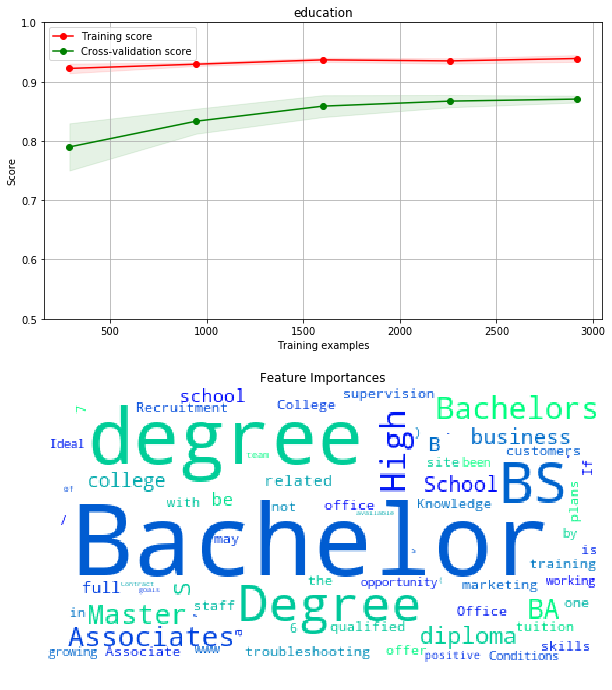

                  precision    recall  f1-score   support

associate-needed       0.37      0.32      0.34       209
bs-degree-needed       0.76      0.84      0.80       970
ms-or-phd-needed       0.57      0.14      0.23        83
            none       0.94      0.94      0.94      3113

     avg / total       0.87      0.87      0.87      4375



In [16]:
def get_model(task, features, max_depth, min_samples_leaf):
    save_path = './results/{}-{}-{}-{}.results.pickle'.format(
        task, features, max_depth, min_samples_leaf
    )
    if os.path.exists(save_path):
        with open(save_path) as fp:
            train_sizes, train_scores, test_scores, preds, model = pickle.load(fp)
    else:
        model = sktree.DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=123
        )
        train_sizes, train_scores, test_scores = learning_curve(
            model, 
            all_features[features], 
            jobs_df[task], 
            cv=3, 
            n_jobs=-1
        )
        preds = cross_val_predict(model, all_features[features], jobs_df[task], cv=3, n_jobs=-1)
        model.fit(all_features[features], jobs_df[task])
        with open(save_path, 'wb') as out:
            pickle.dump((train_sizes, train_scores, test_scores, preds, model), out)
            
    return train_sizes, train_scores, test_scores, preds, model

@interact(task=tasks, features=featurization_approaches.keys(), max_depth=(5, 20, 5), min_samples_leaf=(1, 10, 3))
def display_report(task, features, max_depth, min_samples_leaf):
    global _features_importances
    train_sizes, train_scores, test_scores, preds, model = get_model(
        task, features, max_depth, min_samples_leaf)
    
    fig = plt.figure(figsize=(10, 12))
    learning_curve_ax = fig.add_subplot(2, 1, 1)
    feature_importance_ax = fig.add_subplot(2, 1, 2)
    
    plot_learning_curve(train_sizes, train_scores, test_scores, task, ylim=(0.5, 1.0), ax=learning_curve_ax)
    
    feature_names = all_featurizers[features]
    features_importances = pd.Series(data = model.feature_importances_, index=feature_names)
    features_importances = features_importances[features_importances > 0.0]
    try:
        wordcloud(features_importances, title='Feature Importances', ax=feature_importance_ax)
    except ValueError as e:
        _features_importances = features_importances

    plt.show()
    
    print(skmetrics.classification_report(jobs_df[task], preds))

### Discussion
Once you find the right features/parameters, consider why they worked for that problem.

#### - education
#### - experience
#### - is_hourly
#### - is_part_time
#### - is_supervisor